In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
data=pd.read_csv('sepsis_data_cleaned.csv')

## Random Forest - Undersampled

In [9]:
# Drop non-numeric or ID columns
X = data.drop(columns=['SepsisLabel', 'patient_id'])

# Target variable
y = data['SepsisLabel']

In [11]:
#RF Model data split

# First split: 80% train_val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second split: 60/20 from the 80%, so test_size=0.25
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

In [13]:
#RF Undersample model

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Initialize the undersampler
rus = RandomUnderSampler(random_state=42)

# Apply undersampling only to the training data
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("Class distribution after undersampling:", dict(zip(*np.unique(y_train_resampled, return_counts=True))))

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
rf_val_pred = rf_model.predict(X_val)
rf_val_pred_prob = rf_model.predict_proba(X_val)[:, 1]

# Evaluate performance
rf_accuracy = accuracy_score(y_val, rf_val_pred)
rf_auc = roc_auc_score(y_val, rf_val_pred_prob)

print(f"Random Forest Accuracy (Val): {rf_accuracy:.4f}")
print(f"Random Forest AUC (Val): {rf_auc:.4f}")

Class distribution after undersampling: {0: 4775, 1: 4775}
Random Forest Accuracy (Val): 0.7804
Random Forest AUC (Val): 0.8534


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

# Evaluate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_val, rf_val_pred).ravel()

# Calculate TPR and FPR
tpr_rf = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr_rf = fp / (fp + tn) if (fp + tn) > 0 else 0

# Print metrics
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")
print(f"Random Forest TPR (Recall): {tpr_rf:.4f}")
print(f"Random Forest FPR: {fpr_rf:.4f}")

Random Forest Accuracy: 0.7804
Random Forest AUC: 0.8534
Random Forest TPR (Recall): 0.7538
Random Forest FPR: 0.2191


## LSTM - Class Weights

In [22]:
#data preprocessing for LSTM

In [17]:
def preprocess_data(df):
    
    X = data.drop(columns=['SepsisLabel', 'patient_id'])
    y = data['SepsisLabel']

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Convert data into sequences (for LSTM input)
    sequence_length = 10  # You can adjust this based on your needs
    X_seq = []
    y_seq = []
    
    for i in range(len(X) - sequence_length+1):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length-1])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    
    return X_seq, y_seq

In [19]:
X_seq, y_seq = preprocess_data(data)

In [39]:
# Total number of samples in X_seq and y_seq
total_samples = X_seq.shape[0]

from sklearn.model_selection import train_test_split

# Set desired sizes
train_samples = 279192
val_samples = 93064
test_samples = 93064

# Step 1: test split (exact size)
X_temp, X_test_seq, y_temp, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=test_samples, stratify=y_seq, random_state=42
)

# Step 2: validation split (exact size)
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_temp, y_temp, test_size=val_samples, stratify=y_temp, random_state=42
)

# Verify results
print("X_train_seq:", X_train_seq.shape)
print("X_val_seq:", X_val_seq.shape)
print("X_test_seq:", X_test_seq.shape)

X_train_seq: (279183, 10, 13)
X_val_seq: (93064, 10, 13)
X_test_seq: (93064, 10, 13)


In [21]:
from sklearn.model_selection import train_test_split

# First: train/test split
X_temp, X_test_seq, y_temp, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)

# Second: train/val split
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# Final shapes
print(f"X_train_seq: {X_train_seq.shape}")
print(f"X_val_seq: {X_val_seq.shape}")
print(f"X_test_seq: {X_test_seq.shape}")

X_train_seq: (279186, 10, 13)
X_val_seq: (93062, 10, 13)
X_test_seq: (93063, 10, 13)


In [33]:
#Implement the LSTM model

In [41]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weight_dict = dict(zip(np.unique(y_train_seq), class_weights))

# Reshape input for LSTM: (samples, timesteps, features)
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], -1))
X_val_seq = X_val_seq.reshape((X_val_seq.shape[0], X_val_seq.shape[1], -1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], -1))

# Build model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=10, batch_size=64,
    class_weight=class_weight_dict,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7442 - loss: 0.5967 - val_accuracy: 0.7236 - val_loss: 0.5974
Epoch 2/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7576 - loss: 0.5463 - val_accuracy: 0.7584 - val_loss: 0.5436
Epoch 3/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7677 - loss: 0.5145 - val_accuracy: 0.7685 - val_loss: 0.5108
Epoch 4/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7666 - loss: 0.5048 - val_accuracy: 0.8087 - val_loss: 0.4178
Epoch 5/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7819 - loss: 0.4579 - val_accuracy: 0.8358 - val_loss: 0.3778
Epoch 6/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7867 - loss: 0.4405 - val_accuracy: 0.7738 - val_loss: 0.4607
Epoch 7/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7988 - loss: 0.3973 - val_accuracy: 0.7939 - val_loss: 0.4388
Epoch 8/10
4363/4363 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8055 - loss: 0

In [43]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Predict on validation set
lstm_val_pred_prob = model.predict(X_val_seq)
lstm_val_pred = (lstm_val_pred_prob > 0.5).astype(int)

# Evaluate
accuracy_lstm = accuracy_score(y_val_seq, lstm_val_pred)
auc_lstm = roc_auc_score(y_val_seq, lstm_val_pred)

# Confusion matrix for TPR and FPR
tn, fp, fn, tp = confusion_matrix(y_val_seq, lstm_val_pred).ravel()
tpr_lstm = tp / (tp + fn)
fpr_lstm = fp / (fp + tn)

print(f"LSTM Accuracy: {accuracy_lstm:.4f}")
print(f"LSTM AUC: {auc_lstm:.4f}")
print(f"LSTM TPR (Recall): {tpr_lstm:.4f}")
print(f"LSTM FPR: {fpr_lstm:.4f}")

2909/2909 ━━━━━━━━━━━━━━━━━━━━ 2s 797us/step
LSTM Accuracy: 0.8231
LSTM AUC: 0.7850
LSTM TPR (Recall): 0.7456
LSTM FPR: 0.1755


In [45]:
import numpy as np

# Make sure both are 1D arrays
rf_val_pred = np.array(rf_val_pred).reshape(-1)
lstm_val_pred = np.array(lstm_val_pred).reshape(-1)

# Combine into meta-features
stacking_val_features = np.vstack((rf_val_pred, lstm_val_pred)).T
stacking_val_labels = y_val_seq  # true labels from validation set

print("Shape of stacking features:", stacking_val_features.shape)
print("Shape of stacking labels:", stacking_val_labels.shape)

Shape of stacking features: (93064, 2)
Shape of stacking labels: (93064,)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

meta_clf = LogisticRegression(class_weight='balanced')
meta_clf.fit(stacking_val_features, stacking_val_labels)


# Predict on validation stacking data
stacking_val_pred = meta_clf.predict(stacking_val_features)
stacking_val_prob = meta_clf.predict_proba(stacking_val_features)[:, 1]

# Evaluate
acc_stack = accuracy_score(stacking_val_labels, stacking_val_pred)
auc_stack = roc_auc_score(stacking_val_labels, stacking_val_prob)
tn, fp, fn, tp = confusion_matrix(stacking_val_labels, stacking_val_pred).ravel()
tpr_stack = tp / (tp + fn)
fpr_stack = fp / (fp + tn)

print(f"\n🔗 Stacking Classifier Performance (on Validation Set):")
print(f"Accuracy: {acc_stack:.4f}")
print(f"AUC: {auc_stack:.4f}")
print(f"TPR (Recall): {tpr_stack:.4f}")
print(f"FPR: {fpr_stack:.4f}")


🔗 Stacking Classifier Performance (on Validation Set):
Accuracy: 0.6486
AUC: 0.8759
TPR (Recall): 0.9366
FPR: 0.3564


In [49]:
#Make predictions on the test set
rf_test_pred = rf_model.predict(X_test)
rf_test_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate performance
rf_accuracy_test = accuracy_score(y_test, rf_test_pred)
rf_auc_test = roc_auc_score(y_test, rf_test_pred_prob)


# Evaluate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, rf_test_pred).ravel()

# Calculate TPR and FPR
tpr_rf_test = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr_rf_test = fp / (fp + tn) if (fp + tn) > 0 else 0

# Print metrics
print(f"Random Forest Accuracy: {rf_accuracy_test:.4f}")
print(f"Random Forest AUC: {rf_auc_test:.4f}")
print(f"Random Forest TPR (Recall): {tpr_rf_test:.4f}")
print(f"Random Forest FPR: {fpr_rf_test:.4f}")

Random Forest Accuracy: 0.7766
Random Forest AUC: 0.8620
Random Forest TPR (Recall): 0.7776
Random Forest FPR: 0.2234


In [51]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Predict on test set
lstm_test_pred_prob = model.predict(X_test_seq)
lstm_test_pred = (lstm_test_pred_prob > 0.5).astype(int)

# Evaluate
accuracy_lstm_test = accuracy_score(y_test_seq, lstm_test_pred)
auc_lstm_test = roc_auc_score(y_test_seq, lstm_test_pred)

# Confusion matrix for TPR and FPR
tn, fp, fn, tp = confusion_matrix(y_test_seq, lstm_test_pred).ravel()
tpr_lstm_test = tp / (tp + fn)
fpr_lstm_test = fp / (fp + tn)

print(f"LSTM Accuracy: {accuracy_lstm_test:.4f}")
print(f"LSTM AUC: {auc_lstm_test:.4f}")
print(f"LSTM TPR (Recall): {tpr_lstm_test:.4f}")
print(f"LSTM FPR: {fpr_lstm_test:.4f}")

2909/2909 ━━━━━━━━━━━━━━━━━━━━ 2s 809us/step
LSTM Accuracy: 0.8219
LSTM AUC: 0.7952
LSTM TPR (Recall): 0.7676
LSTM FPR: 0.1771


In [53]:
import numpy as np

# Make sure both are 1D arrays
rf_test_pred = np.array(rf_test_pred).reshape(-1)
lstm_test_pred = np.array(lstm_test_pred).reshape(-1)

# Combine into meta-features
stacking_test_features = np.vstack((rf_test_pred, lstm_test_pred)).T
stacking_test_labels = y_test_seq  # true labels from validation set

print("Shape of stacking features:", stacking_test_features.shape)
print("Shape of stacking labels:", stacking_test_labels.shape)

Shape of stacking features: (93064, 2)
Shape of stacking labels: (93064,)


In [55]:
# Predict on test stacking data
stacking_test_pred = meta_clf.predict(stacking_test_features)
stacking_test_prob = meta_clf.predict_proba(stacking_test_features)[:, 1]

# Evaluate
acc_stack_test = accuracy_score(stacking_test_labels, stacking_test_pred)
auc_stack_test = roc_auc_score(stacking_test_labels, stacking_test_prob)

# Confusion matrix for TPR and FPR
tn, fp, fn, tp = confusion_matrix(stacking_test_labels, stacking_test_pred).ravel()
tpr_stack_test = tp / (tp + fn)
fpr_stack_test = fp / (fp + tn)

# Print test metrics
print(f"\n🔗 Stacking Classifier Performance (on Test Set):")
print(f"Accuracy: {acc_stack_test:.4f}")
print(f"AUC: {auc_stack_test:.4f}")
print(f"TPR (Recall): {tpr_stack_test:.4f}")
print(f"FPR: {fpr_stack_test:.4f}")


🔗 Stacking Classifier Performance (on Test Set):
Accuracy: 0.6668
AUC: 0.8564
TPR (Recall): 0.8769
FPR: 0.3368


In [57]:
#append in results for comparision:
results=[]
results.append({
    'Model': 'Stacking Classifier',
    'Accuracy': acc_stack_test,
    'TPR (Recall)': tpr_stack_test,
    'FPR': fpr_stack_test,
    'ROC AUC': auc_stack_test
})

In [59]:
# Convert to DataFrame for better visualization or saving
import pandas as pd
results_df = pd.DataFrame(results)

In [61]:
results_df

,Model,Accuracy,TPR (Recall),FPR,ROC AUC
0,Stacking Classifier,0.666831,0.876884,0.336824,0.856388


In [63]:
#import other results for analysis

In [65]:
results_lstm= pd.read_csv('lstm_results.csv')
results_ML= pd.read_csv('results_df_ML.csv')

In [71]:
# Rename columns
results_lstm.rename(columns={'model': 'Model', 'AUC': 'ROC AUC'}, inplace=True)

In [73]:
# Combine the DataFrames
final_results = pd.concat([results_ML, results_lstm, results_df], ignore_index=True)

In [75]:
final_results

,Model,Accuracy,TPR (Recall),FPR,ROC AUC
0,Logistic Regression (Imbalanced),0.982840,0.000628,0.000066,0.747827
1,Logistic Regression (Balanced),0.746604,0.650126,0.251716,0.752332
2,Imbalanced RF,0.983828,0.056533,0.000033,0.905303
3,Under-Sampled RF,0.784482,0.778894,0.215421,0.869978
4,Over-Sampled RF,0.984247,0.089824,0.000186,0.908269
5,Hybrid RF (RUS + SMOTE),0.871293,0.692211,0.125590,0.877055
6,Imbalanced XGBoost,0.983484,0.058417,0.000415,0.861279
7,UnderSampled XGBoost,0.770717,0.765075,0.229185,0.846468
8,OverSampled XGBoost,0.978026,0.128141,0.007183,0.812896
9,LSTM_Imbalanced,0.983452,0.094750,0.001377,0.546687


/var/folders/cd/jz0sn5850b5ckqbp3mgr9xv00000gn/T/ipykernel_961/3074349955.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=final_results, ax=axes[0], palette='viridis')
/var/folders/cd/jz0sn5850b5ckqbp3mgr9xv00000gn/T/ipykernel_961/3074349955.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TPR (Recall)', y='Model', data=final_results, ax=axes[1], palette='Blues_d')
/var/folders/cd/jz0sn5850b5ckqbp3mgr9xv00000gn/T/ipykernel_961/3074349955.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='FPR', y=

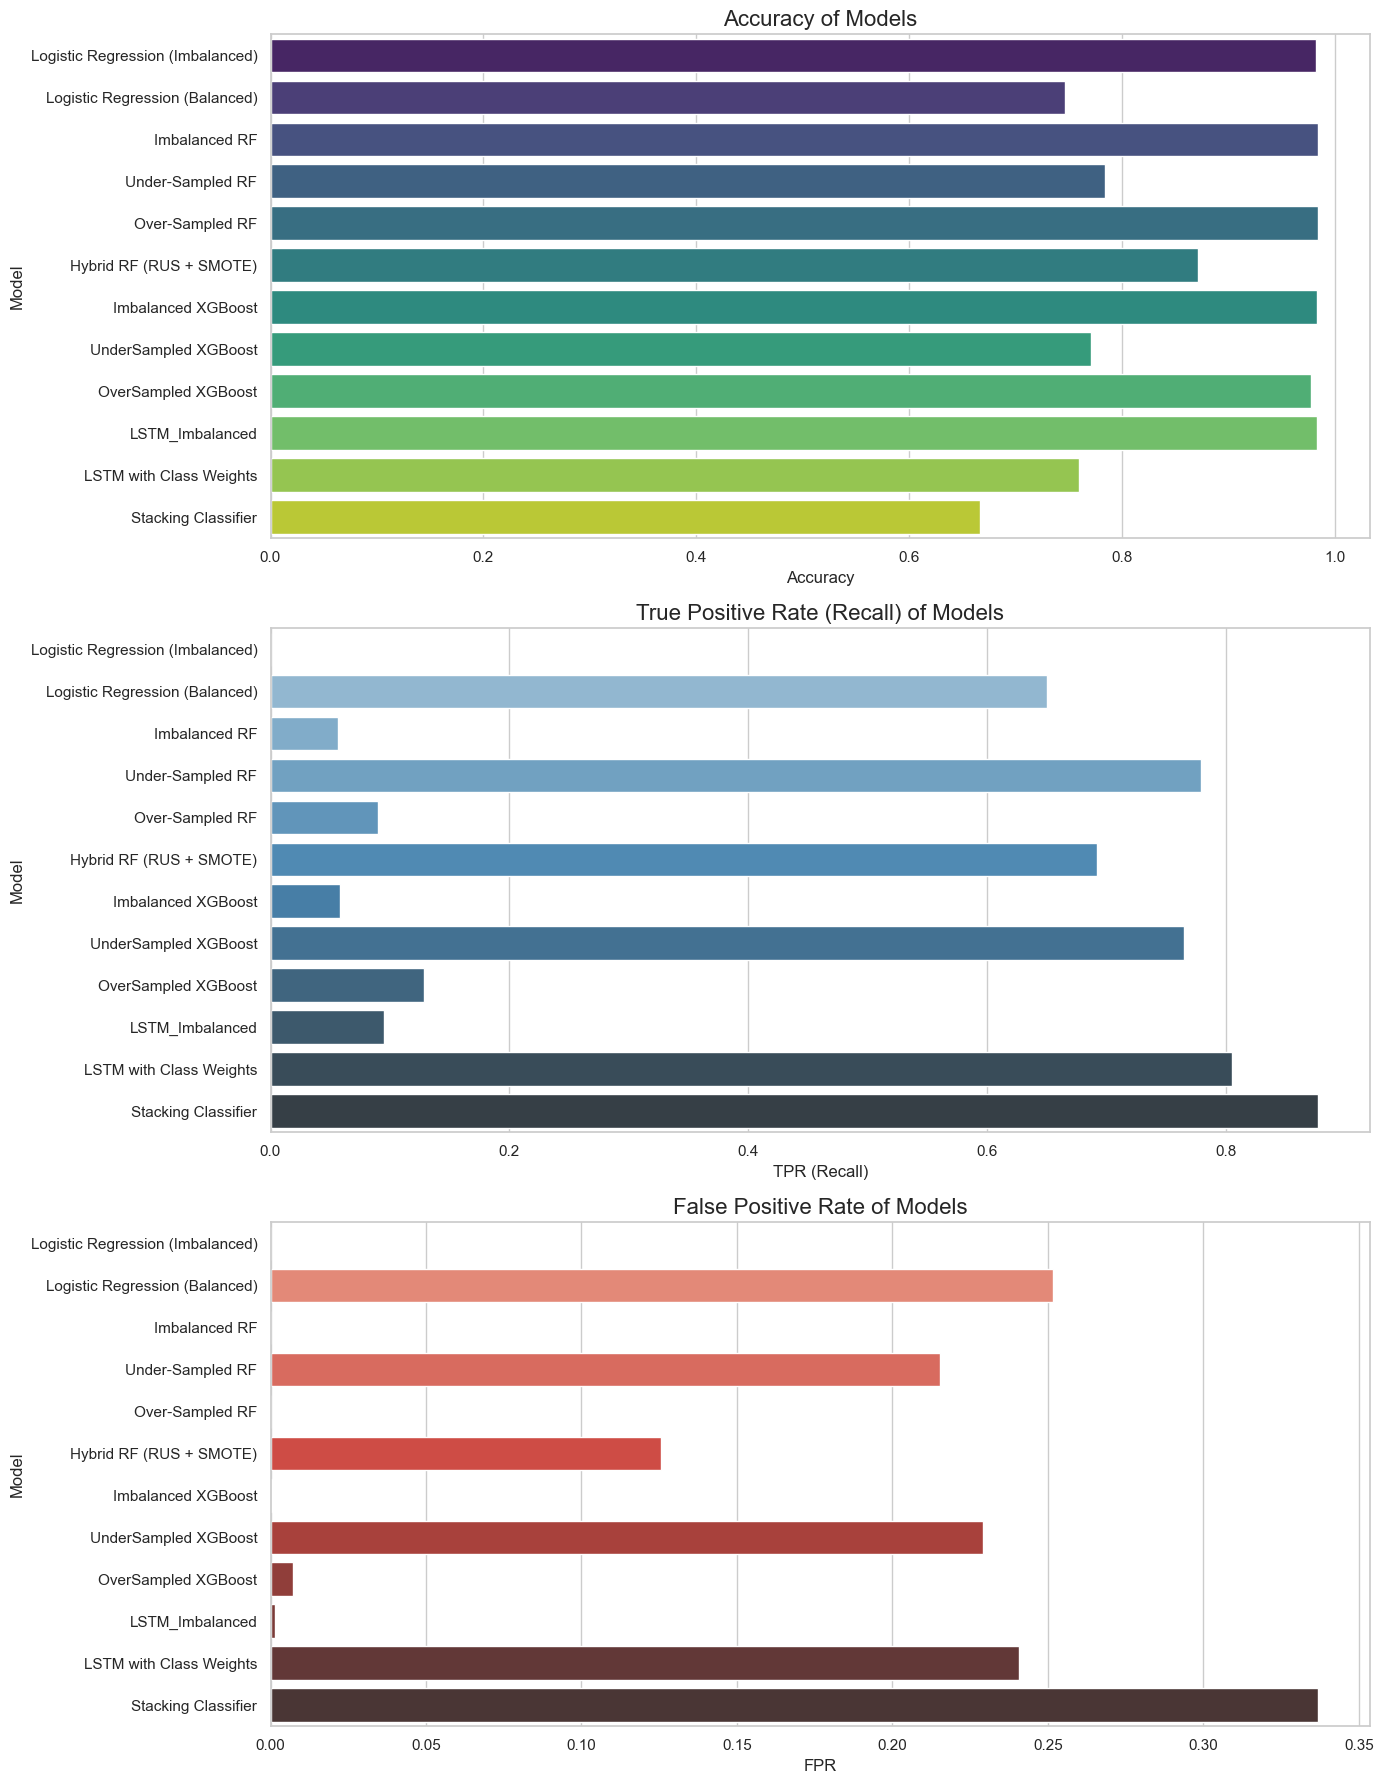

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Plot Accuracy
sns.barplot(x='Accuracy', y='Model', data=final_results, ax=axes[0], palette='viridis')
axes[0].set_title('Accuracy of Models', fontsize=16)
axes[0].set_xlabel('Accuracy')
axes[0].set_ylabel('Model')

# Plot TPR (Recall)
sns.barplot(x='TPR (Recall)', y='Model', data=final_results, ax=axes[1], palette='Blues_d')
axes[1].set_title('True Positive Rate (Recall) of Models', fontsize=16)
axes[1].set_xlabel('TPR (Recall)')
axes[1].set_ylabel('Model')

# Plot FPR
sns.barplot(x='FPR', y='Model', data=final_results, ax=axes[2], palette='Reds_d')
axes[2].set_title('False Positive Rate of Models', fontsize=16)
axes[2].set_xlabel('FPR')
axes[2].set_ylabel('Model')

plt.tight_layout()
plt.show()

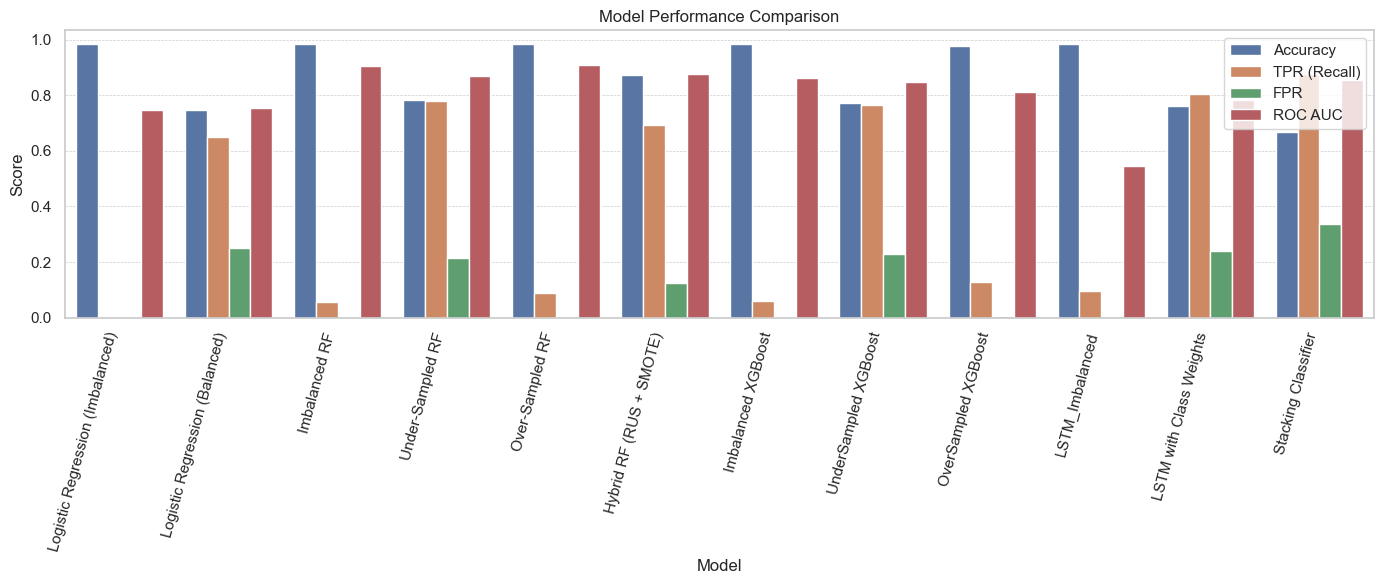

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your final DataFrame
metrics_to_plot = ['Accuracy', 'TPR (Recall)', 'FPR', 'ROC AUC']

# Melt the DataFrame to long format for seaborn
df_melted = final_results.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Value')

plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='Model', y='Value', hue='Metric')
plt.xticks(rotation=75, ha='right')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.tight_layout()
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

/var/folders/cd/jz0sn5850b5ckqbp3mgr9xv00000gn/T/ipykernel_961/3140347501.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_results['Model'], rotation=75, ha='right')
/var/folders/cd/jz0sn5850b5ckqbp3mgr9xv00000gn/T/ipykernel_961/3140347501.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_results['Model'], rotation=75, ha='right')
/var/folders/cd/jz0sn5850b5ckqbp3mgr9xv00000gn/T/ipykernel_961/3140347501.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_results['Model'], rotation=75, ha='right')
/var/folders/cd/jz0sn5850b5ckqbp3mgr9xv00000gn/T/ipykernel_961/3140347501.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. a

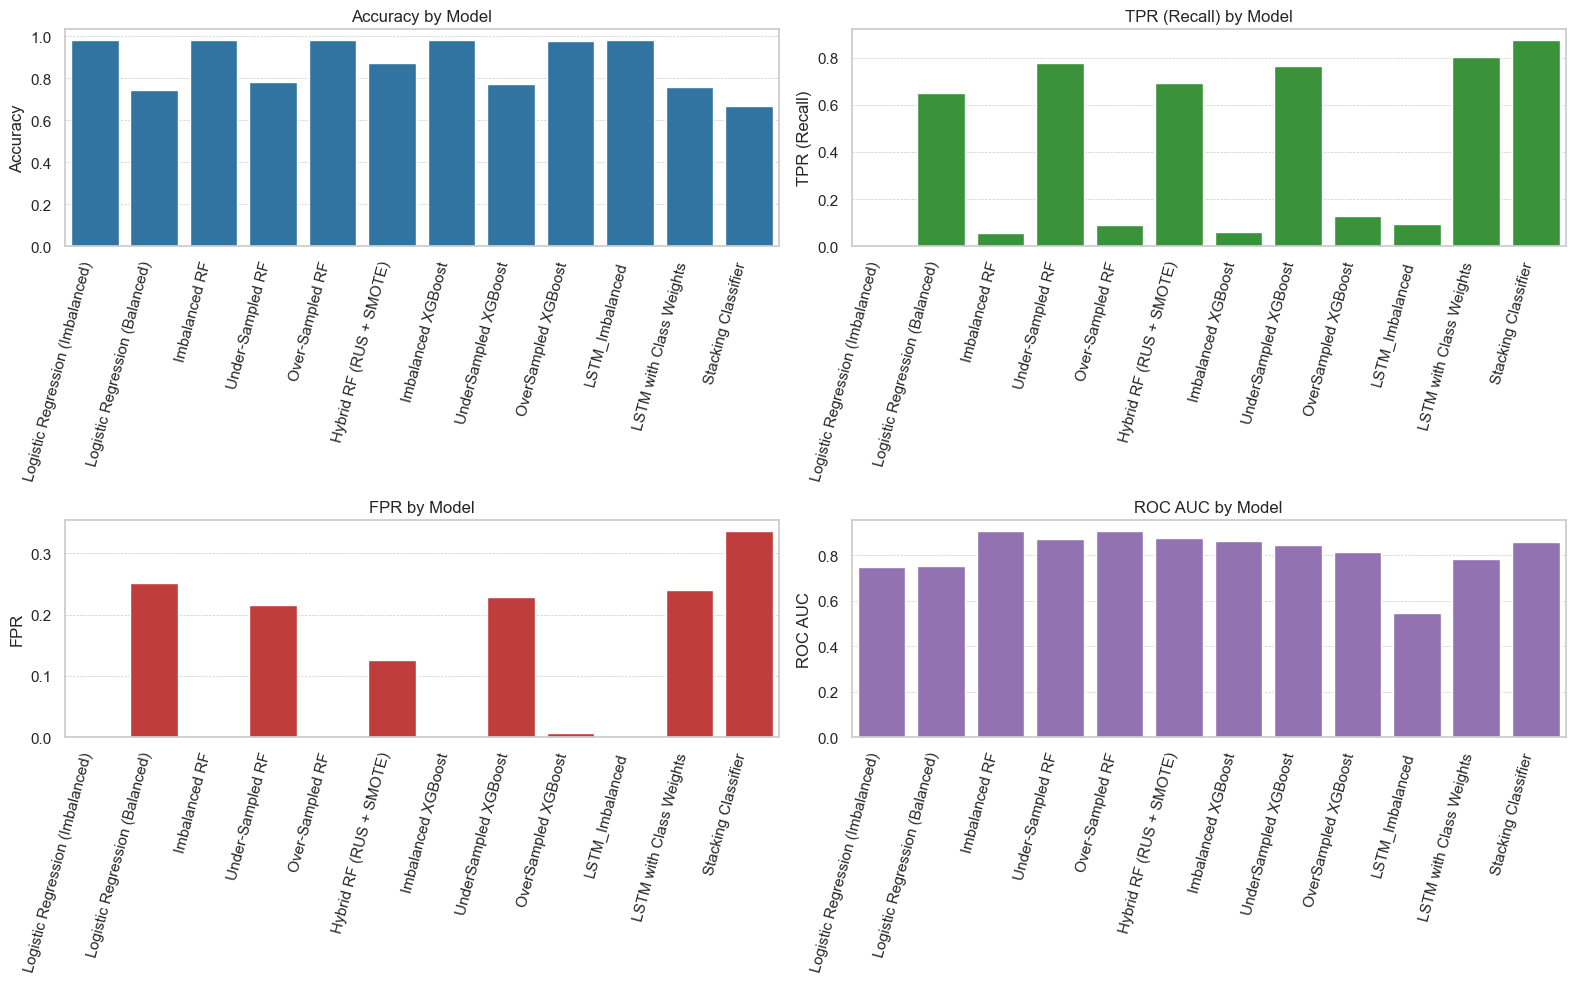

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
metrics = ['Accuracy', 'TPR (Recall)', 'FPR', 'ROC AUC']
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']

for ax, metric, color in zip(axes.flat, metrics, colors):
    sns.barplot(ax=ax, x='Model', y=metric, data=final_results, color=color)
    ax.set_title(f'{metric} by Model')
    ax.set_xticklabels(final_results['Model'], rotation=75, ha='right')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

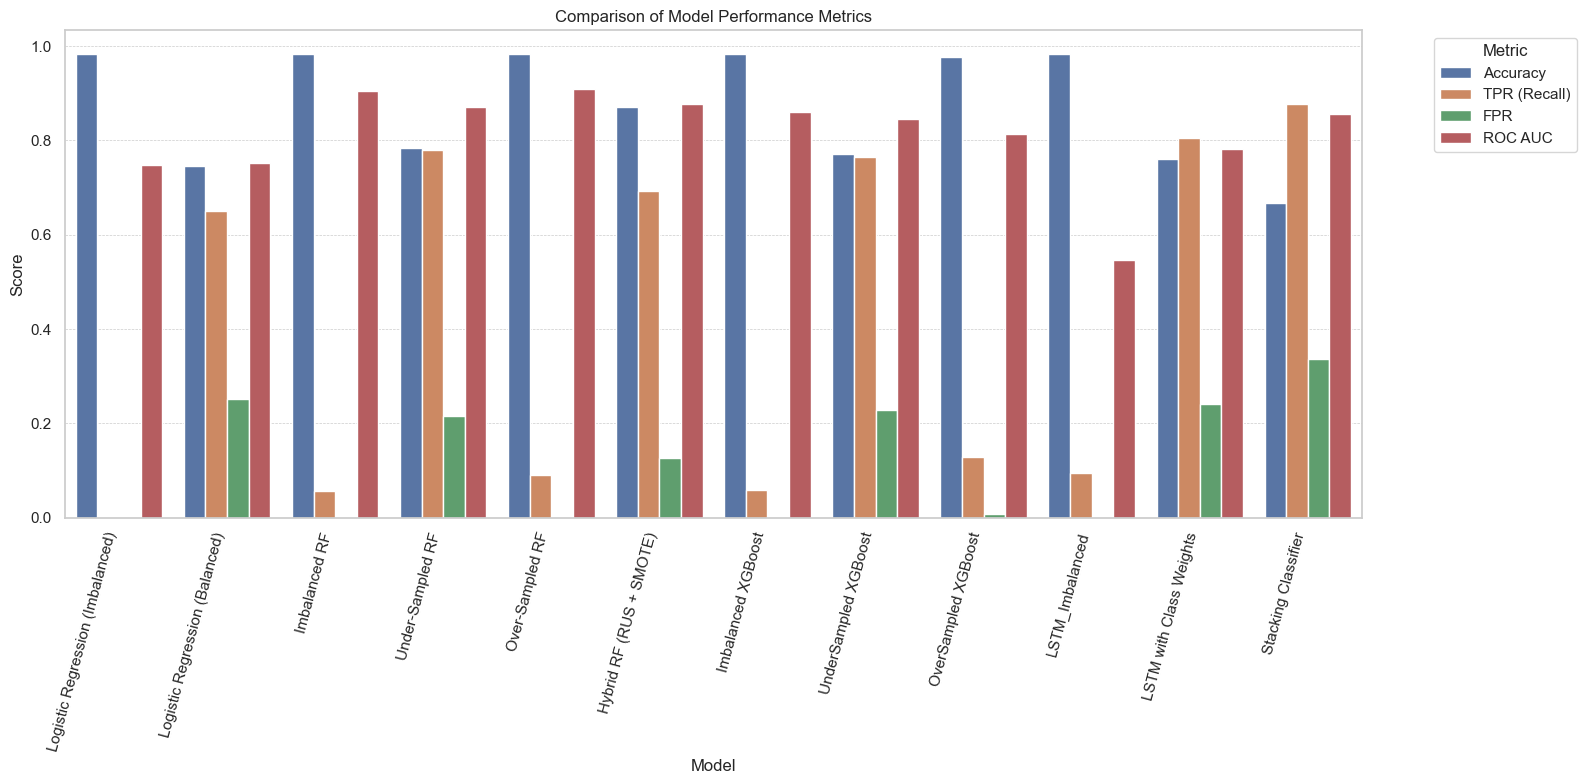

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your DataFrame is named df and contains the following columns:
# ['Model', 'Accuracy', 'TPR (Recall)', 'FPR', 'ROC AUC']

# Convert to long format for easier plotting
df_long = final_results.melt(id_vars='Model', 
                  value_vars=['Accuracy', 'TPR (Recall)', 'FPR', 'ROC AUC'],
                  var_name='Metric', 
                  value_name='Value')

# Plot
plt.figure(figsize=(16, 8))
sns.barplot(data=df_long, x='Model', y='Value', hue='Metric')
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=75, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

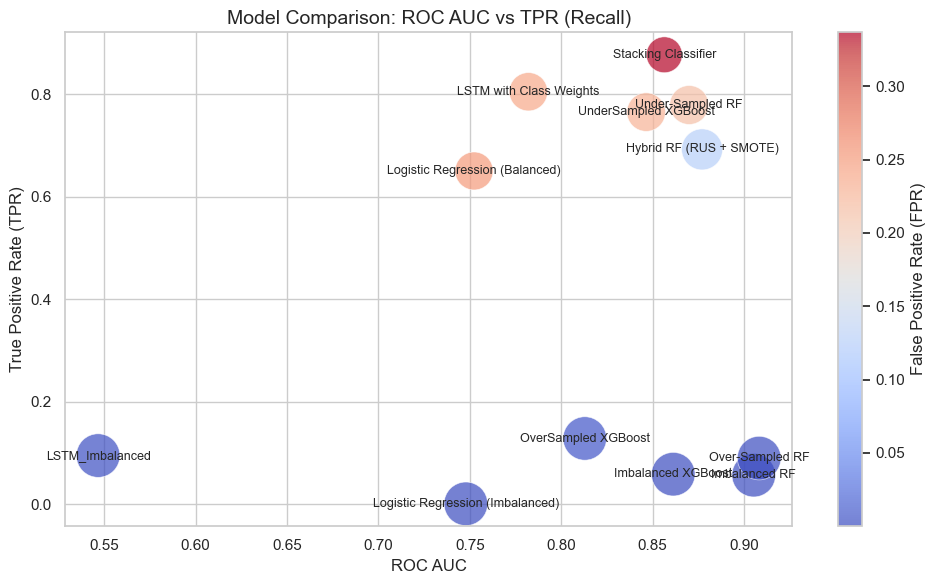

In [97]:
# Plotting the scatter plot
plt.figure(figsize=(10, 6))

# Use ROC AUC on x-axis and TPR on y-axis
plt.scatter(final_results['ROC AUC'], final_results['TPR (Recall)'], s=[a * 1000 for a in final_results['Accuracy']], c=final_results['FPR'], cmap='coolwarm', alpha=0.7, edgecolors='w', linewidth=0.5)

# Adding labels and title
plt.title('Model Comparison: ROC AUC vs TPR (Recall)', fontsize=14)
plt.xlabel('ROC AUC', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)

# Annotate with model names
for i, model in enumerate(models):
    plt.annotate(model, (roc_auc[i], tpr[i]), fontsize=9, ha='center', va='center')

# Show color bar for FPR
plt.colorbar(label='False Positive Rate (FPR)')

# Show the plot
plt.tight_layout()
plt.show()

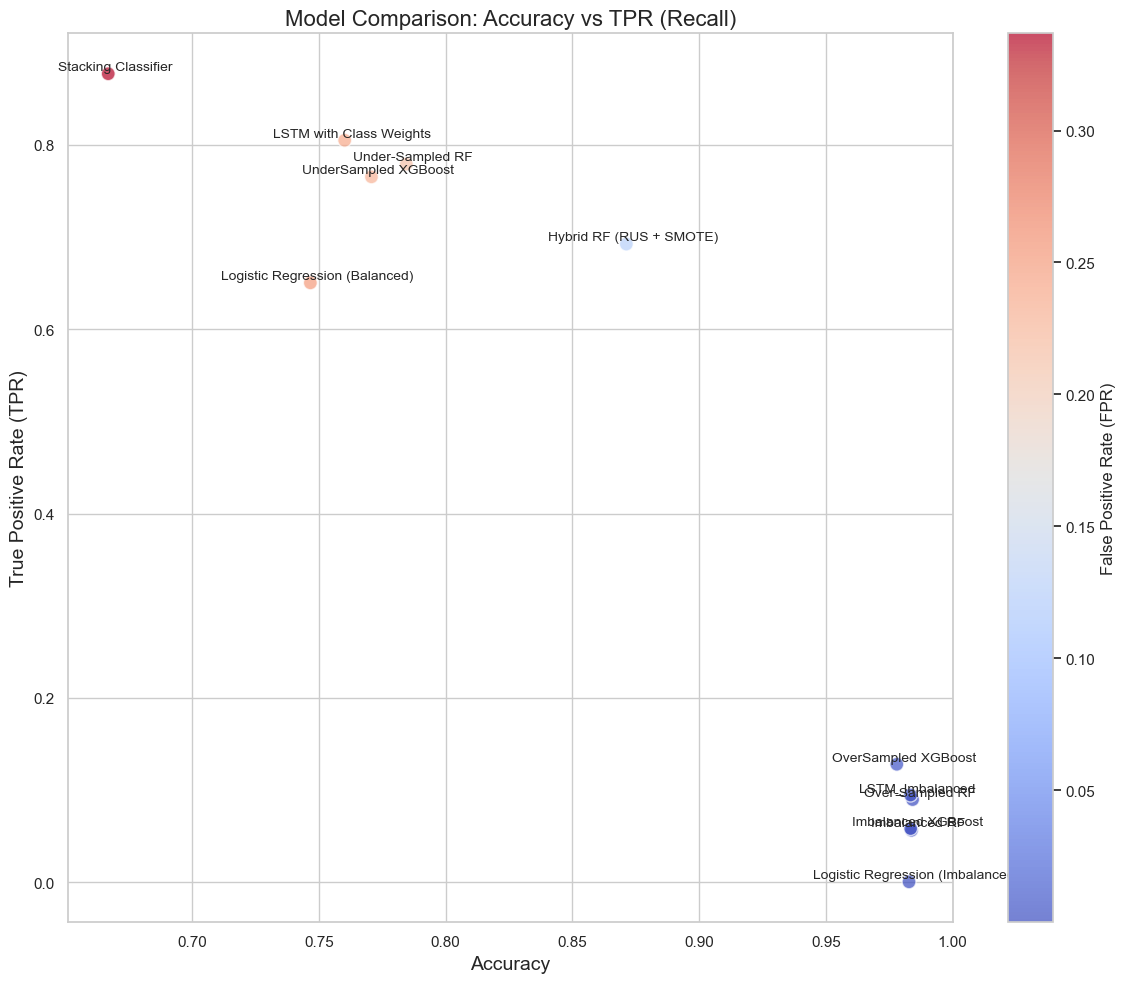

In [115]:
import matplotlib.pyplot as plt

# Plotting the graph
plt.figure(figsize=(12, 10))  # Increased figure size for more space

# Use Accuracy on x-axis, TPR on y-axis, and color by FPR
scatter = plt.scatter(final_results['Accuracy'], final_results['TPR (Recall)'], c=final_results['FPR'], cmap='coolwarm', s=100, edgecolors='w', alpha=0.7)

# Adding labels and title
plt.title('Model Comparison: Accuracy vs TPR (Recall)', fontsize=16)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)

# Annotate with model names with a slight offset to prevent overlap
for i, model in enumerate(final_results['Model']):
    plt.annotate(model,
                 (final_results['Accuracy'][i], final_results['TPR (Recall)'][i]),
                 fontsize=10,
                 ha='center',
                 va='center',
                 xytext=(5, 5),  # Small offset to avoid overlap
                 textcoords='offset points')

# Show color bar for FPR
plt.colorbar(scatter, label='False Positive Rate (FPR)')

# Show the plot
plt.tight_layout()
plt.show()




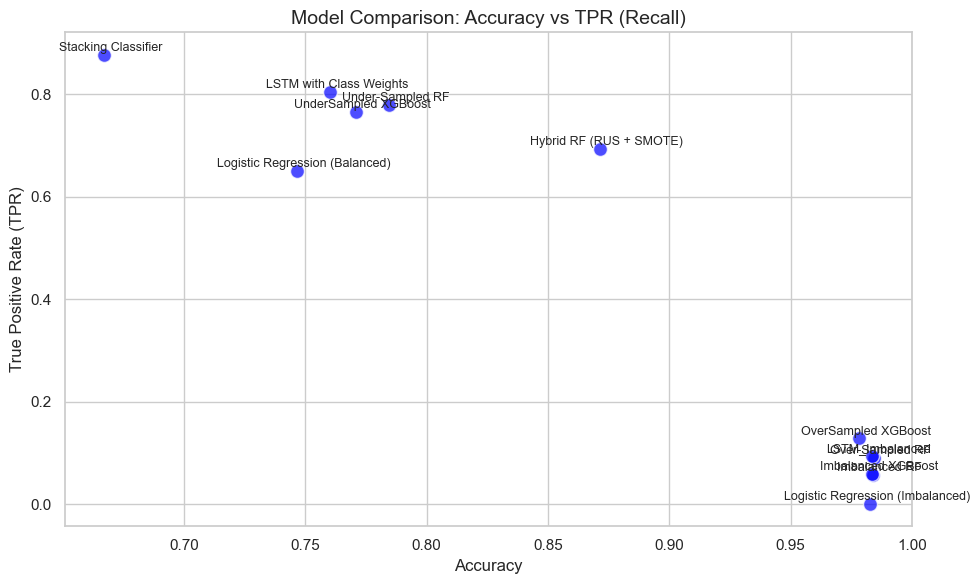

In [117]:
import matplotlib.pyplot as plt

# Plotting the graph
plt.figure(figsize=(10, 6))  # Adjust the figure size

# Use Accuracy on x-axis, TPR on y-axis (no color, no size)
plt.scatter(final_results['Accuracy'], final_results['TPR (Recall)'], s=100, color='blue', alpha=0.7, edgecolors='w')

# Adding labels and title
plt.title('Model Comparison: Accuracy vs TPR (Recall)', fontsize=14)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)

# Annotate with model names
for i, model in enumerate(final_results['Model']):
    plt.annotate(model,
                 (final_results['Accuracy'][i], final_results['TPR (Recall)'][i]),
                 fontsize=9,
                 ha='center',
                 va='center',
                 xytext=(5, 5),  # Small offset to avoid overlap
                 textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()
